In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Project/

Mounted at /content/drive
/content/drive/MyDrive/Project


In [2]:
# load best model
load_model = False

# 1. 데이터셋 불러오기

데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다.

STL10 dataset은 10개의 label을 갖습니다.

In [3]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import pandas as pd
import openpyxl

# saliency
import numpy as np

# VGGnet
from model.VGGnet import VGGnet

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
# specify a data path
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
test_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
train_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [6]:
# check train_ds
img, _ = train_ds[1]
print(img.shape)

print(len(train_ds))
print(len(test_ds))

torch.Size([3, 96, 96])
8000
5000


In [7]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.44723064 0.4396425 0.40495726
0.4467106 0.43980986 0.40664646


In [8]:
# define the image transformation
# using FiveCrop, normalize, horizontal reflection
train_transformer = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(224),
                    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
])

# apply transformation
train_ds.transform = train_transformer
test_ds.transform = train_transformer

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images indices:  2732


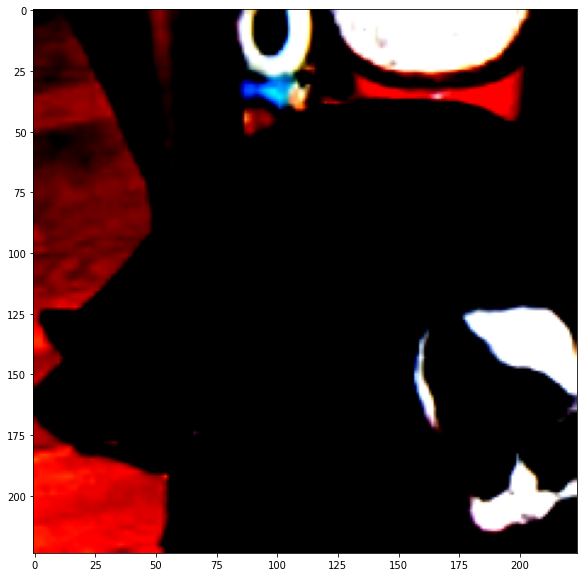

In [9]:
# display transformed sample images

def show(imgs, y=None, color=True):
    # for i, img in enumerate(imgs):
    #     npimg = img.numpy()
    #     npimg_tr = np.transpose(npimg, (1, 2, 0))
    #     plt.subplot(1, imgs.shape[0], i+1)
    #     plt.imshow(npimg_tr)

    npimg = imgs.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)
    
    # plt.imshow(npimg_tr)
    if y is not None:
        plt.title('labels: ' + str(y))

np.random.seed(0)
torch.manual_seed(0)

# pick a random sample image
rnd_inds = int(np.random.randint(0, len(train_ds), 1))
img, label = train_ds[rnd_inds]
print('images indices: ', rnd_inds)

plt.figure(figsize=(10, 10))
show(img)

In [10]:
# create dataloader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

# 2. 모델 정보

In [11]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [12]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# creat VGGnet object
if load_model:
    model = VGGnet('D', in_channels=3, num_classes=10, init_weights=True).to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    checkpoint = torch.load('./models/VGGnet_model.pt')
    model.load_state_dict(checkpoint['model'])
    model.to(device=device)

    loss_func = nn.CrossEntropyLoss(reduction="sum")
    opt.load_state_dict(checkpoint['optimizer'])
    current_lr = checkpoint['lr']
    best_loss = checkpoint['best_val_loss']
    exp_dir = checkpoint['exp_dir']
    print('Loading model: ', 'VGGnet')
    print(model)
else :
    model = VGGnet('D', in_channels=3, num_classes=10, init_weights=True).to(device)

    loss_func = nn.CrossEntropyLoss(reduction="sum")
    opt = optim.Adam(model.parameters(), lr=0.001)
    current_lr = get_lr(opt)
    print(model)

# define learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

# print model summary
summary(model, input_size=(3, 224, 224), device=device.type)

cuda
VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3,

# 3. 모델 학습하기

In [13]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output = model(xb)
        # Five crop : bs, crops, chnnel, h, w
        # making dimmension (bs, c, h, w)
        # bs, ncrops, c, h, w = xb.size()
        # output_=model(xb.view(-1, c, h, w))
        # output = output_.view(bs, ncrops, -1).mean(1)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [14]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # 가중치를 저장할 때, 코랩 GPU 오류나서 생략했습니다.
    # a deep copy of weights for the best performing model
    # best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # check start time
    start_time = time.time()
    # main loop
    for epoch in range(num_epochs):
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,test_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            print('new best loss')
            torch.save(
                {
                    'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer': opt.state_dict(),
                    'best_val_loss': best_loss,
                    'lr': current_lr,
                    'exp_dir': './models/'
                },
                f='./models/VGGnet_model.pt'
            )
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step()

        print("train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f s" %(train_loss,val_loss,100*val_metric, time.time()-start_time))
        print("-"*10) 

    ## load best model weights
    # model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [17]:
# definc the training parameters
params_train = {
    'num_epochs':40,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'test_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [18]:
# train model
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/39, current lr=0.001
new best loss
train loss: 2.220452, val loss: 2.089721, accuracy: 18.28, time: 415.2287 s
----------
Epoch 1/39, current lr=0.001
train loss: 2.194695, val loss: 2.109987, accuracy: 19.74, time: 780.5234 s
----------
Epoch 2/39, current lr=0.001
train loss: 2.112117, val loss: 2.100232, accuracy: 16.48, time: 1145.4735 s
----------
Epoch 3/39, current lr=0.001
train loss: 2.098324, val loss: 2.275111, accuracy: 14.78, time: 1511.0536 s
----------
Epoch 4/39, current lr=0.001
new best loss
train loss: 1.994059, val loss: 2.014075, accuracy: 18.16, time: 1892.5883 s
----------
Epoch 5/39, current lr=0.001
new best loss
train loss: 1.911888, val loss: 1.873741, accuracy: 19.34, time: 2274.3877 s
----------
Epoch 6/39, current lr=0.001
new best loss
train loss: 1.886676, val loss: 1.792460, accuracy: 22.62, time: 2651.3442 s
----------
Epoch 7/39, current lr=0.001
new best loss
train loss: 1.855224, val loss: 1.719547, accuracy: 30.08, time: 3030.2969 s
-------

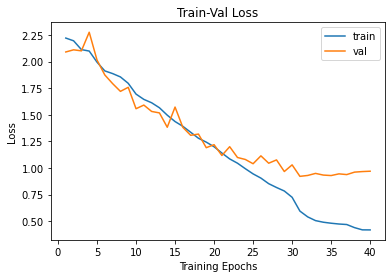

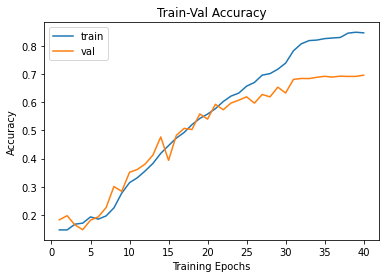

In [19]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]
train_loss_hist = loss_hist["train"]
val_loss_hist = loss_hist["val"]
train_acc_hist = metric_hist["train"]
val_acc_hist = metric_hist["val"]

# convert list to dataframe and save to excel
df = pd.DataFrame([train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist],
                  index=['train_loss','val_loss','train_accuracy','val_accuracy'], columns=range(0,num_epochs))
path2df = './graph'
if not os.path.exists(path2df):
    os.mkdir(path2df)
df.to_excel('./graph/VGGNet.xlsx', sheet_name='VGGNet')

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [20]:
corrects = 0
test_len = len(test_dl)
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        pred = output.argmax(dim=1, keepdim=True)
        correct = yb.eq(pred.view_as(yb)).sum()
        corrects += correct/32

print('Accuracy : %2d %%' % (
    100 * corrects / test_len))

Accuracy : 69 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


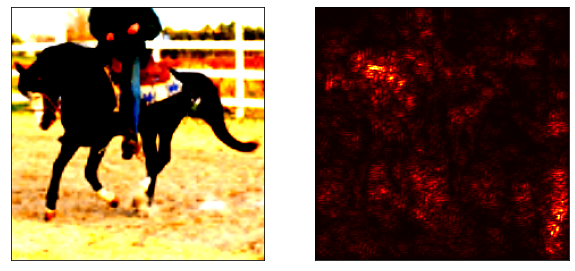

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


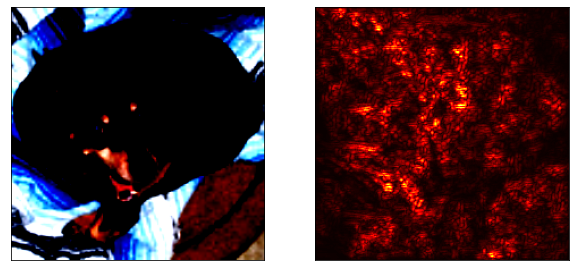

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


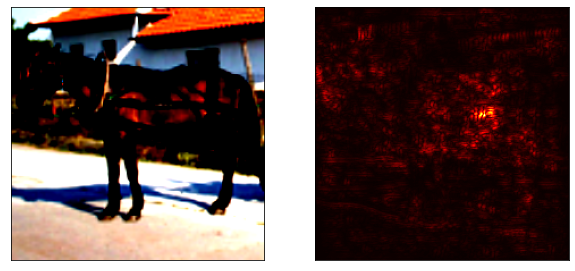

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


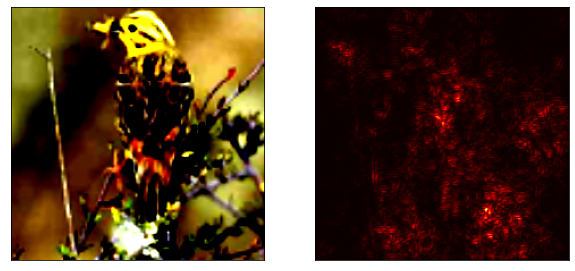

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


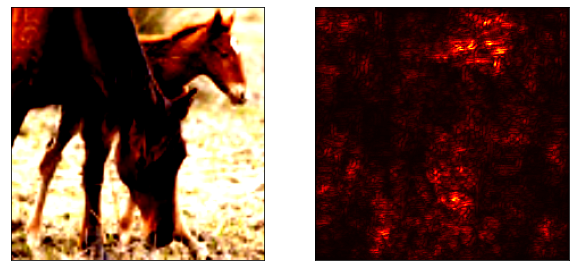

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


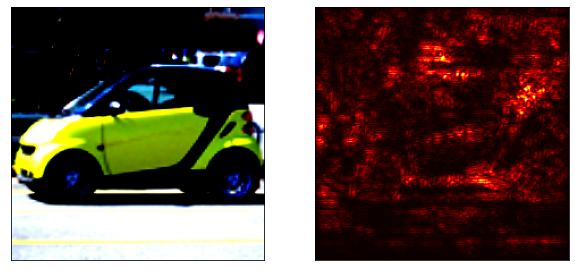

In [22]:
def saliency(input, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    preds = preds.view(10)
    score, indices = torch.max(preds, 0)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = input[0]
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    out1 = np.transpose(input_img.detach().cpu().numpy(), (1, 2, 0))
    plt.imshow(out1)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    out2 = slc.cpu().numpy()
    plt.imshow(out2, cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

input1 = train_ds[0][0].to(device)
saliency(input1, model)

input2 = train_ds[15][0].to(device)
saliency(input2, model)

input3 = train_ds[25][0].to(device)
saliency(input3, model)

input4 = test_ds[0][0].to(device)
saliency(input4, model)

input5 = test_ds[15][0].to(device)
saliency(input5, model)

input6 = test_ds[4809][0].to(device)
saliency(input6, model)